In [1]:
import requests
import os
from tqdm import tqdm

def download_file(link, file_name):
    response = requests.get(link, stream=True)
    if os.path.exists(file_name):
        print(f"The file {file_name} already exists, the file won't be downloaded")
        return
    total_size = int(response.headers.get('content-length', 0))

    with open(file_name, "wb") as f, tqdm(desc="Downloading file", total=total_size, unit='B', unit_scale=True, unit_divisor=1024,) as bar:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
                bar.update(len(chunk))  # Update progress bar by the chunk size

model_file_name = "ms2deepscore_model.pt"
neg_test_spectra_file_name = "neg_testing_spectra.mgf"
pos_test_spectra_file_name = "pos_testing_spectra.mgf"

download_file("https://zenodo.org/records/14290920/files/settings.json?download=1", "ms2deepscore_settings.json")
download_file("https://zenodo.org/records/14290920/files/ms2deepscore_model.pt?download=1", model_file_name)
download_file("https://zenodo.org/records/13934470/files/negative_testing_spectra.mgf?download=1", neg_test_spectra_file_name)
download_file("https://zenodo.org/records/13934470/files/positive_testing_spectra.mgf?download=1", pos_test_spectra_file_name)

The file ms2deepscore_settings.json already exists, the file won't be downloaded
The file ms2deepscore_model.pt already exists, the file won't be downloaded
The file neg_testing_spectra.mgf already exists, the file won't be downloaded
The file pos_testing_spectra.mgf already exists, the file won't be downloaded


In [2]:
from matchms.importing import load_from_mgf
from tqdm import tqdm
import os

pos_test = list(tqdm(load_from_mgf(pos_test_spectra_file_name)))
neg_test = list(tqdm(load_from_mgf(neg_test_spectra_file_name)))

24911it [00:08, 2815.87it/s]
7142it [00:02, 2493.48it/s]


In [3]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_between_ionmodes = CalculateScoresBetweenAllIonmodes(model_file_name, pos_test, neg_test, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/bin/miniconda3/envs/ms2deepscore_2_5_4/lib/python3.12/site-packages/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

Calculating embeddings


Computing spectral embeddings ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7142/7142 [00:07<00:00, 960.60it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 299.93it/s]


Calculating tanimoto scores
Calculating embeddings


Computing spectral embeddings ...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24911/24911 [00:25<00:00, 975.30it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:05<00:00, 310.71it/s]


Calculating tanimoto scores
Calculating embeddings


Computing spectral embeddings ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7142/7142 [00:07<00:00, 975.63it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 297.14it/s]


Calculating tanimoto scores


# Create combined dataset

In [4]:
import pandas as pd
import numpy as np
# Top: A vs (A + B)
tanimoto_pos_across = pd.concat([scores_between_ionmodes.pos_vs_pos_scores.tanimoto_df, scores_between_ionmodes.pos_vs_neg_scores.tanimoto_df], axis=1)

# Bottom: B vs (A + B)
tanimoto_neg_across = pd.concat([scores_between_ionmodes.pos_vs_neg_scores.tanimoto_df.T, scores_between_ionmodes.neg_vs_neg_scores.tanimoto_df], axis=1)

# Full combined DataFrame
tanimoto_scores_combined = pd.concat([tanimoto_pos_across, tanimoto_neg_across], axis=0)
tanimoto_scores_combined = tanimoto_scores_combined[~tanimoto_scores_combined.index.duplicated()]
tanimoto_scores_combined = tanimoto_scores_combined.loc[:, ~tanimoto_scores_combined.columns.duplicated()]


In [5]:
# Top: A vs (A + B)
predictions_pos_across = pd.concat([scores_between_ionmodes.pos_vs_pos_scores.predictions_df, scores_between_ionmodes.pos_vs_neg_scores.predictions_df], axis=1)

# Bottom: B vs (A + B)
predictions_neg_across = pd.concat([scores_between_ionmodes.pos_vs_neg_scores.predictions_df.T, scores_between_ionmodes.neg_vs_neg_scores.predictions_df], axis=1)

# Full combined DataFrame
predictions_combined = pd.concat([predictions_pos_across, predictions_neg_across], axis=0)


# Get top N prediction for best hit
Below we calculate the position for the best possible analogue. 
First we select the actual best possible hit per inchikey, by selecting the analogue with the highest tanimoto score. After that we check at which rank it actually is predicted.

In [115]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# same as below, but not averaging per inchikey
def get_rank_for_best_possible_analogue(tanimoto_scores, predictions, title=""):
    mask = tanimoto_scores.index.to_series().values[:, None] == tanimoto_scores.columns.to_series().values
    tanimoto_scores = tanimoto_scores.mask(mask)
    max_indices = tanimoto_scores.idxmax(axis=1)
    ranks = []
    weights = []
    for inchikey in tqdm(predictions.index.unique()):
        rows_matching_inchikey = predictions.loc[[inchikey]]
        weight = 1/len(rows_matching_inchikey)
        for _, row in rows_matching_inchikey.iterrows():
            ranked_predictions = row.rank(ascending=False, method='min')
            best_predicition = max_indices[inchikey]
            if best_predicition not in predictions.columns:
                lowest_rank = predictions.shape[1]
            else:
                ranks_of_best_analogue = ranked_predictions.loc[[best_predicition]]
                lowest_rank = min(ranks_of_best_analogue)
            ranks.append(lowest_rank)
            weights.append(weight)
    ranks = pd.Series(ranks)
    weights = pd.Series(weights)
    for rank in (1, 3, 10, 50, 100):
        print(f"Best hit within top {rank} = {weights[ranks <= rank].sum()/len(predictions.index.unique())*100:.1f}%")
    plt.hist(ranks, bins=100, weights=weights)
    plt.ylabel("count")
    plt.xlabel(f"Rank of best possible analogue (out of {predictions.shape[1]})")
    plt.title(title)
    plt.show()
    return ranks

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:07<00:00, 119.26it/s]


Best hit within top 1 = 1.4%
Best hit within top 3 = 6.2%
Best hit within top 10 = 13.6%
Best hit within top 50 = 27.7%
Best hit within top 100 = 36.2%


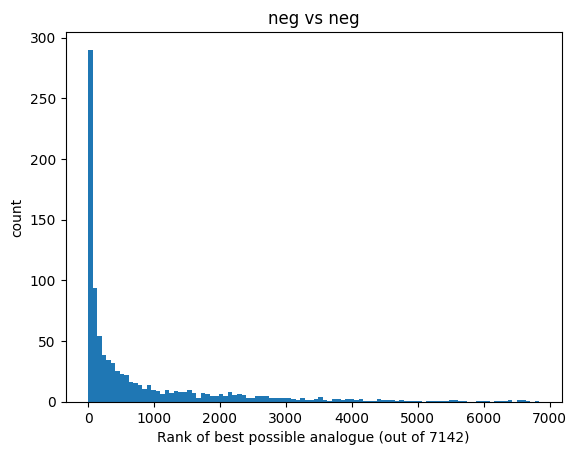

In [9]:
ranks = get_rank_for_best_possible_analogue(scores_between_ionmodes.neg_vs_neg_scores.tanimoto_df.copy(deep=True), scores_between_ionmodes.neg_vs_neg_scores.predictions_df.copy(deep=True), "neg vs neg")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:27<00:00, 67.63it/s]

Best hit within top 1 = 4.3%
Best hit within top 3 = 6.9%
Best hit within top 10 = 11.4%
Best hit within top 50 = 22.8%
Best hit within top 100 = 30.6%


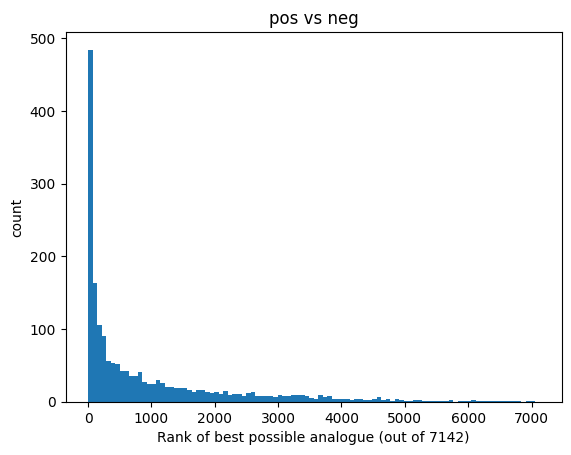

In [10]:
ranks = get_rank_for_best_possible_analogue(scores_between_ionmodes.pos_vs_neg_scores.tanimoto_df.copy(deep=True), scores_between_ionmodes.pos_vs_neg_scores.predictions_df.copy(deep=True), "pos vs neg")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:21<00:00, 43.47it/s]

Best hit within top 1 = 3.8%
Best hit within top 3 = 6.0%
Best hit within top 10 = 11.1%
Best hit within top 50 = 21.2%
Best hit within top 100 = 27.2%


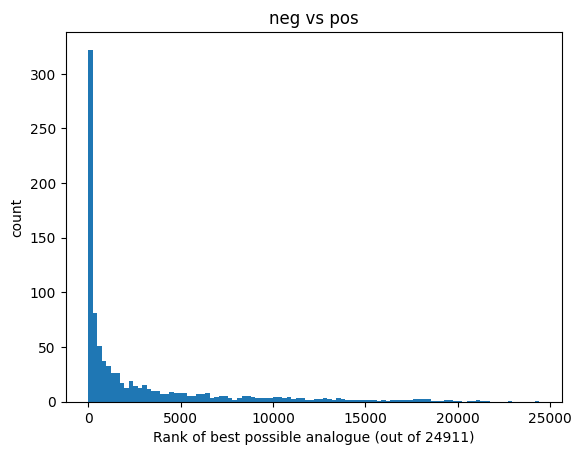

In [11]:
ranks = get_rank_for_best_possible_analogue(scores_between_ionmodes.pos_vs_neg_scores.tanimoto_df.copy(deep=True).T, scores_between_ionmodes.pos_vs_neg_scores.predictions_df.copy(deep=True).T, "neg vs pos")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [01:18<00:00, 23.39it/s]

Best hit within top 1 = 4.2%
Best hit within top 3 = 8.9%
Best hit within top 10 = 14.9%
Best hit within top 50 = 25.0%
Best hit within top 100 = 30.5%


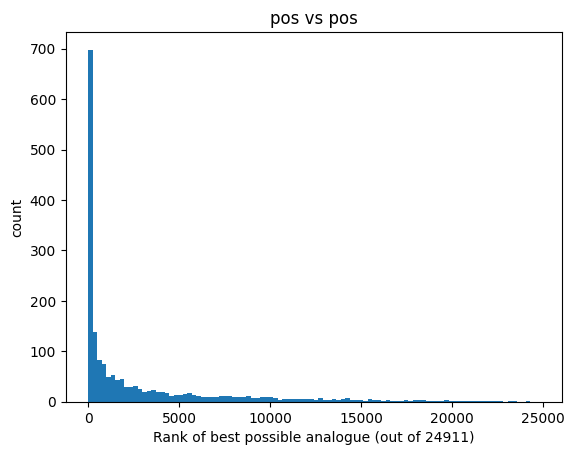

In [12]:
ranks = get_rank_for_best_possible_analogue(scores_between_ionmodes.pos_vs_pos_scores.tanimoto_df.copy(deep=True), scores_between_ionmodes.pos_vs_pos_scores.predictions_df.copy(deep=True), "pos vs pos")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:06<00:00, 139.31it/s]

Best hit within top 1 = 1.1%
Best hit within top 3 = 4.0%
Best hit within top 10 = 8.4%
Best hit within top 50 = 16.9%
Best hit within top 100 = 21.4%


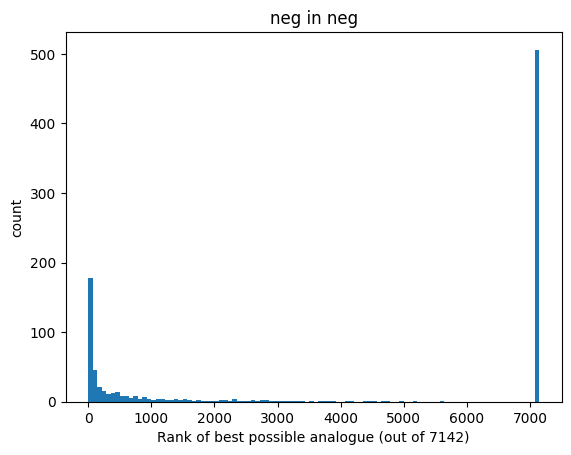

In [13]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, scores_between_ionmodes.neg_vs_neg_scores.predictions_df.copy(deep=True), "neg in neg")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:40<00:00, 22.95it/s]


Best hit within top 1 = 1.1%
Best hit within top 3 = 3.9%
Best hit within top 10 = 9.6%
Best hit within top 50 = 20.8%
Best hit within top 100 = 28.0%


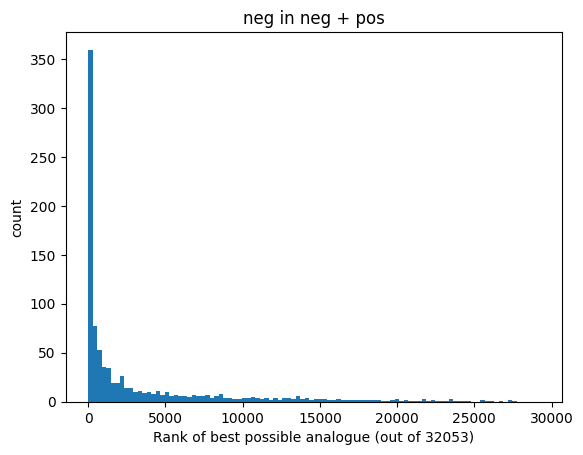

In [154]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, predictions_neg_across, "neg in neg + pos")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [01:29<00:00, 20.54it/s]


Best hit within top 1 = 3.9%
Best hit within top 3 = 8.0%
Best hit within top 10 = 12.9%
Best hit within top 50 = 20.6%
Best hit within top 100 = 24.6%


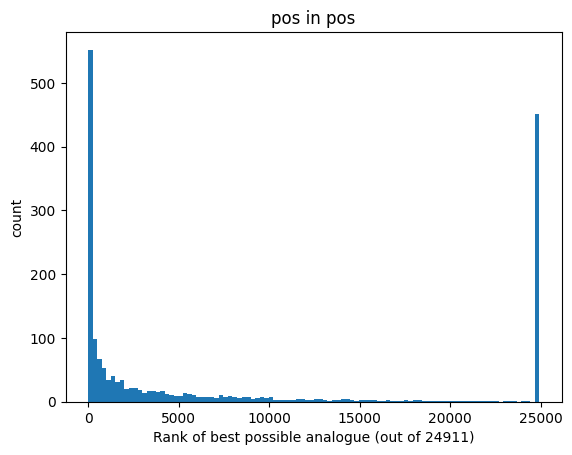

In [155]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, scores_between_ionmodes.pos_vs_pos_scores.predictions_df.copy(deep=True), "pos in pos")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [02:06<00:00, 14.43it/s]


Best hit within top 1 = 3.9%
Best hit within top 3 = 8.3%
Best hit within top 10 = 13.4%
Best hit within top 50 = 21.9%
Best hit within top 100 = 27.0%


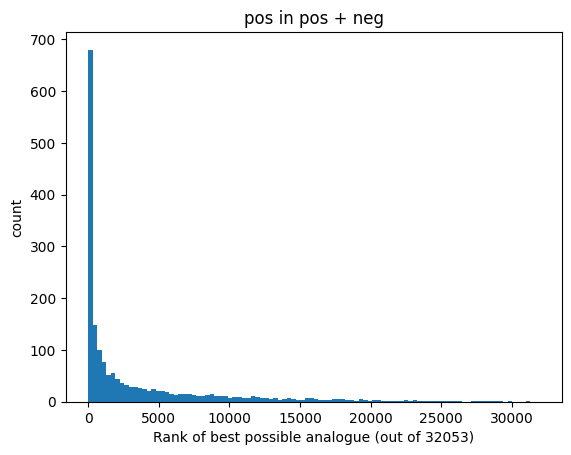

In [156]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, predictions_pos_across, "pos in pos + neg")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1831/1831 [00:24<00:00, 76.13it/s]


Best hit within top 1 = 1.2%
Best hit within top 3 = 1.8%
Best hit within top 10 = 3.2%
Best hit within top 50 = 6.6%
Best hit within top 100 = 9.7%


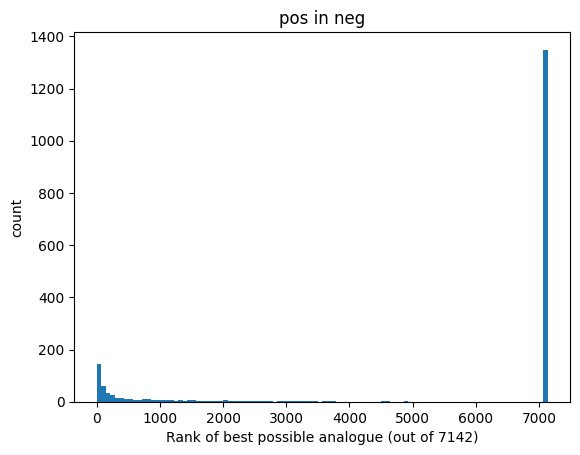

In [157]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, scores_between_ionmodes.pos_vs_neg_scores.predictions_df.copy(deep=True), "pos in neg")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:21<00:00, 43.64it/s]

Best hit within top 1 = 2.0%
Best hit within top 3 = 3.4%
Best hit within top 10 = 6.0%
Best hit within top 50 = 11.5%
Best hit within top 100 = 15.2%


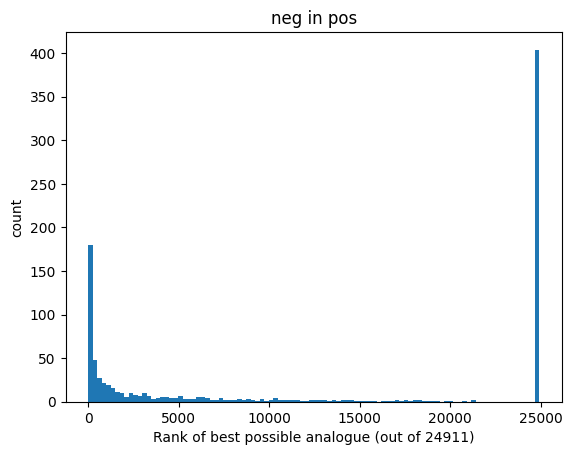

In [158]:
ranks = get_rank_for_best_possible_analogue(tanimoto_scores_combined, scores_between_ionmodes.pos_vs_neg_scores.predictions_df.copy(deep=True).T, "neg in pos")

# New qualitative analysis

### Select one spectrum per unique molecule

In [14]:
import random

def select_one_spectrum_per_inchikey(spectra):
    random.seed(0)
    shuffled_spectra = random.sample(spectra, len(spectra))
    selected_spectra = []
    inchikeys = []
    for spectrum in shuffled_spectra:
        inchikey = spectrum.get("inchikey")[:14]
        if inchikey not in inchikeys:
            selected_spectra.append(spectrum)
            inchikeys.append(inchikey)
    return selected_spectra
selected_pos_spectra = select_one_spectrum_per_inchikey(pos_test)
selected_neg_spectra = select_one_spectrum_per_inchikey(neg_test)

### Select equal number of pos and neg spectra

In [15]:
print("nr of pos spectra: ", len(selected_pos_spectra))
print("nr of neg spectra: ", len(selected_neg_spectra))

nr of pos spectra:  1831
nr of neg spectra:  924


In [16]:
selected_pos_spectra = random.sample(selected_pos_spectra, 924)

In [17]:
len(selected_pos_spectra)

924

In [19]:
from ms2deepscore.benchmarking.CalculateScoresBetweenAllIonmodes import CalculateScoresBetweenAllIonmodes
scores_selected_spectra = CalculateScoresBetweenAllIonmodes(model_file_name, selected_pos_spectra, selected_neg_spectra, fingerprint_type="daylight", n_bits_fingerprint=4096)

/lustre/BIF/nobackup/jonge094/bin/miniconda3/envs/ms2deepscore_2_5_4/lib/python3.12/site-packages/ms2deepscore/models/load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fe

Calculating embeddings


Computing spectral embeddings ...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:00<00:00, 981.18it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 302.54it/s]


Calculating tanimoto scores
Calculating embeddings


Computing spectral embeddings ...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:00<00:00, 965.97it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:02<00:00, 308.65it/s]


Calculating tanimoto scores
Calculating embeddings


Computing spectral embeddings ...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:00<00:00, 956.69it/s]


Calculating similarity between embeddings


Calculating fingerprints: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 924/924 [00:03<00:00, 301.31it/s]


Calculating tanimoto scores


In [20]:
import pandas as pd
import numpy as np
# Top: A vs (A + B)
tanimoto_pos_across_selected = pd.concat([scores_selected_spectra.pos_vs_pos_scores.tanimoto_df, scores_selected_spectra.pos_vs_neg_scores.tanimoto_df], axis=1)

# Bottom: B vs (A + B)
tanimoto_neg_across_selected = pd.concat([scores_selected_spectra.pos_vs_neg_scores.tanimoto_df.T, scores_selected_spectra.neg_vs_neg_scores.tanimoto_df], axis=1)

# # Full combined DataFrame
tanimoto_scores_combined_selected = pd.concat([tanimoto_pos_across_selected, tanimoto_neg_across_selected], axis=0)
tanimoto_scores_combined_selected = tanimoto_scores_combined_selected[~tanimoto_scores_combined_selected.index.duplicated()]
tanimoto_scores_combined_selected = tanimoto_scores_combined_selected.loc[:, ~tanimoto_scores_combined_selected.columns.duplicated()]

In [21]:
# Top: A vs (A + B)
predictions_selected_pos_across = pd.concat([scores_selected_spectra.pos_vs_pos_scores.predictions_df, scores_selected_spectra.pos_vs_neg_scores.predictions_df], axis=1)

# Bottom: B vs (A + B)
predictions_selected_neg_across = pd.concat([scores_selected_spectra.pos_vs_neg_scores.predictions_df.T, scores_selected_spectra.neg_vs_neg_scores.predictions_df], axis=1)

# Full combined DataFrame
selected_predictions_combined = pd.concat([predictions_pos_across, predictions_neg_across], axis=0)

In [22]:
predictions_selected_pos_across

,NRJAVPSFFCBXDT,MKLDEWFVEYBALZ,BZPSPRCKSLUNLL,HWOYIOLMBQSTQS,NOFXXAHHOJWYAL,BMOUOZDRMBLNSI,ISDXXBVYCIDTIV,OGYHCBGORZWBPH,QROUXKTXCYBOMI,UPNUIXSCZBYVBB,...,HAKKEJDMTIQLJH,YOQYZTXXADEVBO,BFSYFTQDGRDJNV,ZYGHJZDHTFUPRJ,DRCNWQYEKZTTEW,UAWMVMPAYRWUFX,SWXOGPJRIDTIRL,DRKMHDAKULCOKQ,FHRSHSOEWXUORL,MLMQPDHYNJCQAO
NRJAVPSFFCBXDT,NaN,0.194549,0.115784,0.131730,0.113714,0.126555,0.217745,0.248239,0.131942,0.150872,...,0.785167,0.071041,0.171194,0.037562,0.052776,0.120091,0.253410,0.174036,0.000206,0.018121
MKLDEWFVEYBALZ,0.194549,NaN,0.413801,0.240198,0.129411,0.455072,0.000000,0.235106,0.428245,0.331519,...,0.070524,0.322217,0.164105,0.030790,0.426683,0.153607,0.317068,0.566204,0.398134,0.056239
BZPSPRCKSLUNLL,0.115784,0.413801,NaN,0.416319,0.227605,0.310978,0.000000,0.113253,0.461965,0.514393,...,0.109746,0.390078,0.294370,0.000000,0.461051,0.090114,0.214720,0.454460,0.425878,0.000000
HWOYIOLMBQSTQS,0.131730,0.240198,0.416319,NaN,0.249123,0.453025,0.009756,0.061796,0.335912,0.516476,...,0.186562,0.374310,0.368488,0.000000,0.284829,0.069592,0.361925,0.213998,0.118526,0.000000
NOFXXAHHOJWYAL,0.113714,0.129411,0.227605,0.249123,NaN,0.212357,0.000000,0.239087,0.199228,0.182794,...,0.162045,0.246064,0.240040,0.087211,0.554966,0.020639,0.280040,0.105331,0.249380,0.086432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NRVUFSWVIXWMBG,0.093371,0.139181,0.020089,0.144926,0.195357,0.167113,0.410636,0.418978,0.147424,0.378780,...,0.056186,0.487575,0.415432,0.380830,0.214858,0.392353,0.258215,0.064447,0.391916,0.155547
HTLIACAXGNCSQG,0.067526,0.444294,0.337664,0.361642,0.053822,0.145749,0.238073,0.222772,0.308937,0.452314,...,0.075936,0.484547,0.512569,0.148399,0.286178,0.379830,0.371878,0.526305,0.551206,0.172843
OIUBYZLTFSLSBY,0.144427,0.468972,0.349775,0.289805,0.119462,0.372012,0.001586,0.052541,0.382922,0.247942,...,0.071434,0.053858,0.099460,0.011177,0.272231,0.000000,0.102274,0.287385,0.201878,0.000000
XPNPKQSCYZUYBU,0.082341,0.344051,0.429673,0.381992,0.520841,0.293086,0.080399,0.176680,0.434956,0.368955,...,0.135822,0.299688,0.466223,0.155258,0.624799,0.014181,0.368185,0.322950,0.414855,0.100585


In [23]:
def get_prediction_error(tanimoto_scores, predictions, row_idx, col_idx, min_prediction):
    """Calculates the prediction error for a single point in the df"""
    prediction = predictions.iat[row_idx,col_idx]
    row_inchikey = predictions.index[row_idx]
    col_inchikey = predictions.columns[col_idx]
    tanimoto_score = tanimoto_scores.loc[row_inchikey, col_inchikey]
    error = tanimoto_score-prediction
    if prediction> min_prediction:
        return abs(error)

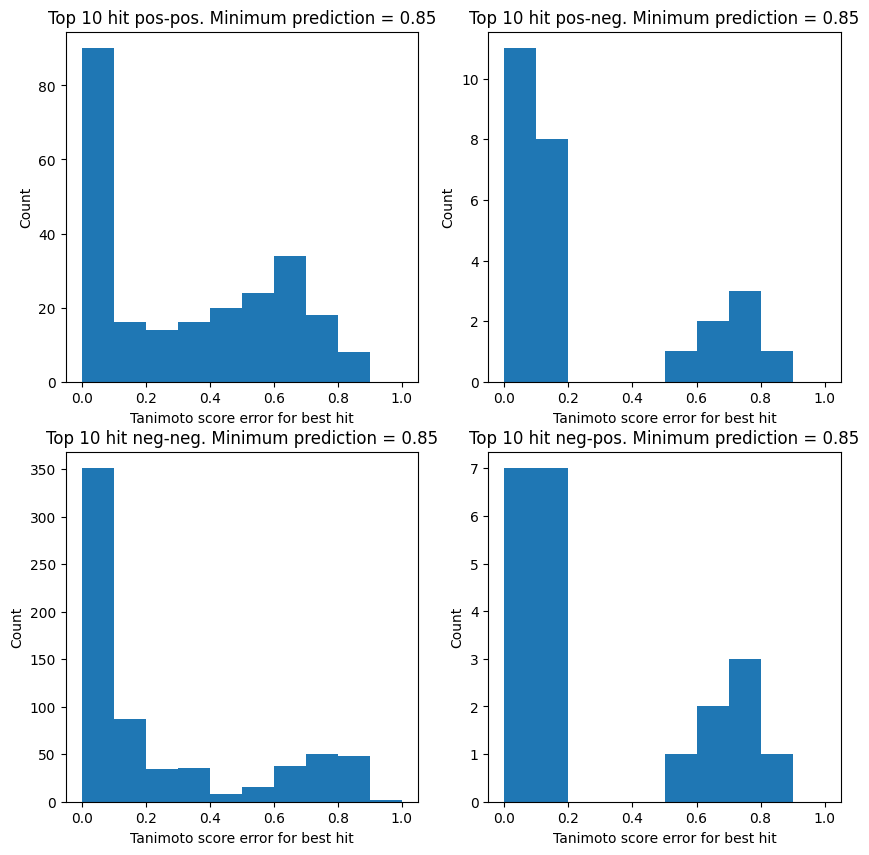

In [24]:
def plot_error_for_highest_hits(min_prediction, number_of_top_hits, pos_predictions, neg_predictions, tanimoto_scores):
    bins = np.linspace(0, 1, 11)
    top_1_index_of_highest_prediction = np.argsort(-pos_predictions.values, axis=1)[:, :number_of_top_hits]
    
    errors_pos_pos = []
    errors_pos_neg = []
    
    for row_idx, col_idxes in enumerate(top_1_index_of_highest_prediction):
        for col_idx in col_idxes:
            error = get_prediction_error(tanimoto_scores, pos_predictions, row_idx, col_idx, min_prediction)
            if error is not None:
                if col_idx < 924:
                    errors_pos_pos.append(error)
                else:
                    errors_pos_neg.append(error)

    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    
    weights = np.ones_like(errors_pos_pos) / len(top_1_index_of_highest_prediction)*100
    axs[0, 0].hist(errors_pos_pos, bins= bins
             # weights = weights
                   
            )
    axs[0, 0].set_title(f"Top {number_of_top_hits} hit pos-pos. Minimum prediction = {min_prediction}")
    axs[0, 0].set_xlabel("Tanimoto score error for best hit")
    axs[0, 0].set_ylabel("Count")
    
    weights = np.ones_like(errors_pos_neg) / len(top_1_index_of_highest_prediction)*100
    axs[0, 1].hist(errors_pos_neg, bins= bins
             # weights = weights
            )
    axs[0, 1].set_title(f"Top {number_of_top_hits} hit pos-neg. Minimum prediction = {min_prediction}")
    axs[0, 1].set_xlabel("Tanimoto score error for best hit")
    axs[0, 1].set_ylabel("Count")


    # Do the same for the neg mode
    top_1_index_of_highest_prediction = np.argsort(-neg_predictions.values, axis=1)[:, :number_of_top_hits]
    # neg_pos_predictions = sum(1 for x in top_1_index_of_highest_prediction if x < 924)
    # neg_neg_predictions = sum(1 for x in top_1_index_of_highest_prediction if x > 924)
    # print("number of neg neg highest predictions", neg_neg_predictions)
    # print("Number of neg pos highest predictions", neg_pos_predictions)
    
    errors_neg_pos = []
    errors_neg_neg = []
    
    for row_idx, col_idxes in enumerate(top_1_index_of_highest_prediction):
        for col_idx in col_idxes:
            error = get_prediction_error(tanimoto_scores_combined_selected, neg_predictions, row_idx, col_idx, min_prediction)
            if error is not None:
                if col_idx < 924:
                    errors_neg_pos.append(error)
                else:
                    errors_neg_neg.append(error)
    
    weights = np.ones_like(errors_neg_neg) / len(top_1_index_of_highest_prediction)*100
    axs[1, 0].hist(errors_neg_neg, bins= bins
             # weights = weights
            )
    axs[1, 0].set_title(f"Top {number_of_top_hits} hit neg-neg. Minimum prediction = {min_prediction}")
    axs[1, 0].set_xlabel("Tanimoto score error for best hit")
    axs[1, 0].set_ylabel("Count")
    
    weights = np.ones_like(errors_neg_pos) / len(top_1_index_of_highest_prediction)*100
    axs[1, 1].hist(errors_neg_pos, bins= bins
             # weights = weights
            )
    axs[1, 1].set_title(f"Top {number_of_top_hits} hit neg-pos. Minimum prediction = {min_prediction}")
    axs[1,1].set_xlabel("Tanimoto score error for best hit")
    axs[1, 1].set_ylabel("Count")

    
plot_error_for_highest_hits(0.85, 10, predictions_selected_pos_across, predictions_selected_neg_across, tanimoto_scores_combined_selected)
# plt.savefig("Top10_min85.svg", bbox_inches='tight')
plt.show()

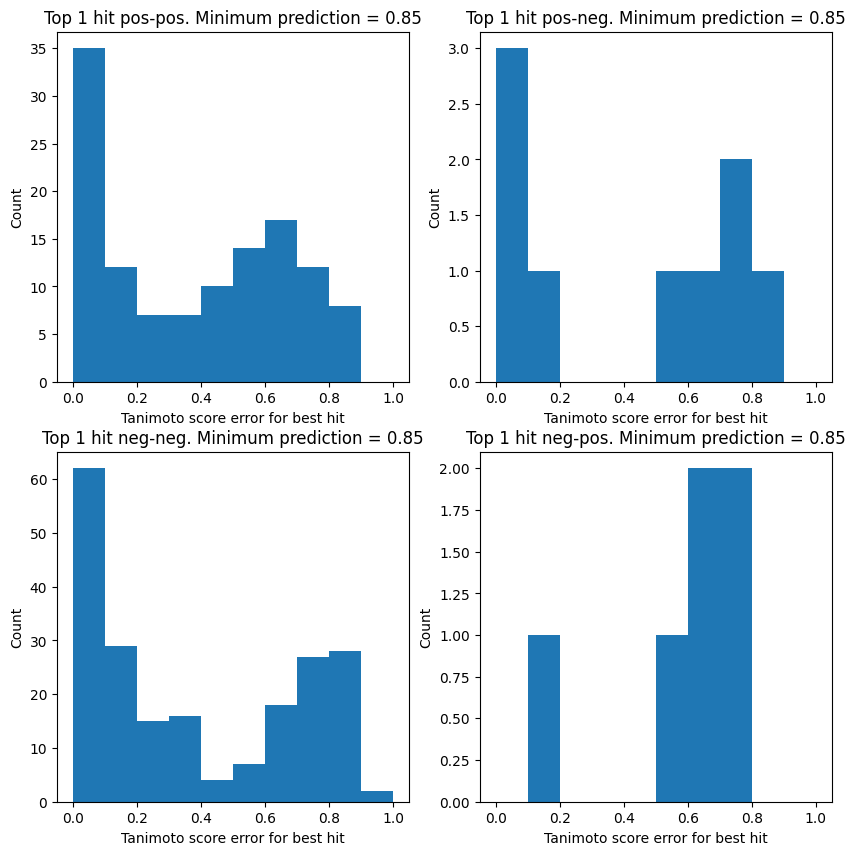

In [25]:
plot_error_for_highest_hits(0.85, 1, predictions_selected_pos_across, predictions_selected_neg_across, tanimoto_scores_combined_selected)
# plt.savefig("Top1_min85.svg", bbox_inches='tight')
plt.show()

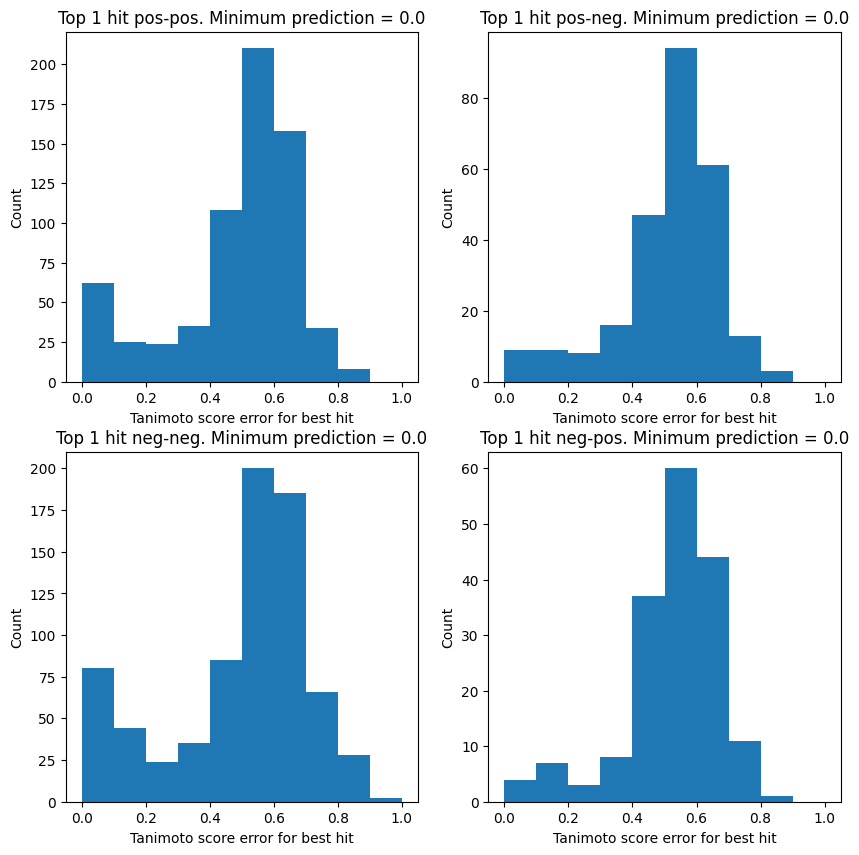

In [26]:
plot_error_for_highest_hits(0.0, 1, predictions_selected_pos_across, predictions_selected_neg_across, tanimoto_scores_combined_selected)
# plt.savefig("Top1_min0.svg", bbox_inches='tight')
plt.show()

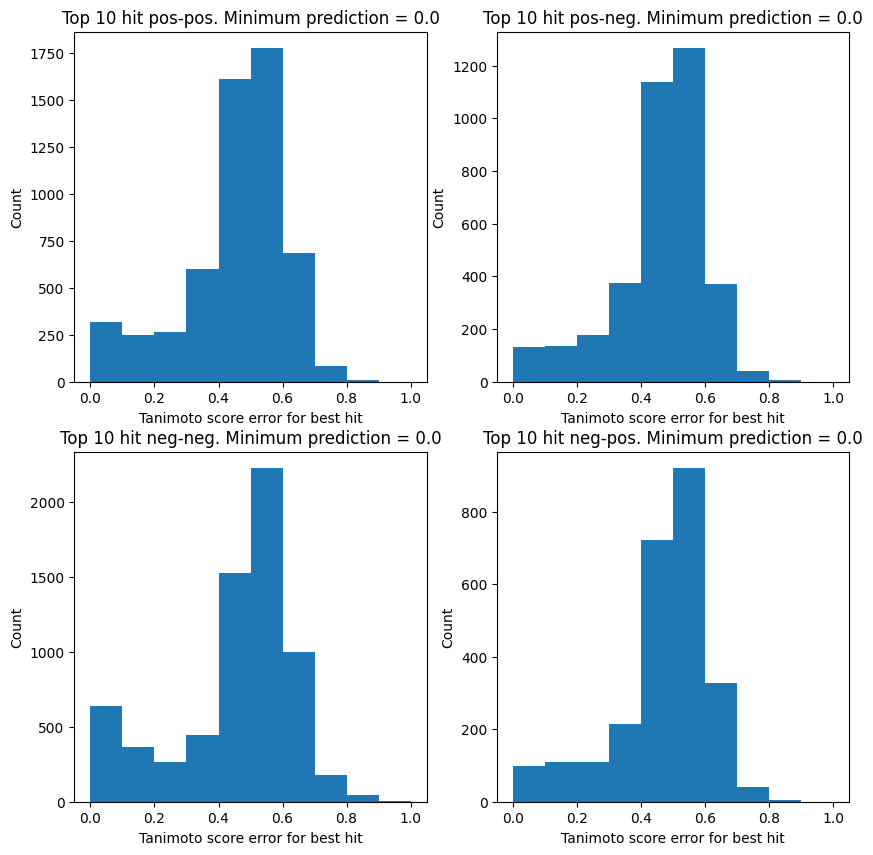

In [27]:
plot_error_for_highest_hits(0.0, 10, predictions_selected_pos_across, predictions_selected_neg_across, tanimoto_scores_combined_selected)
# plt.savefig("Top10_min0.svg", bbox_inches='tight')
plt.show()